# Hospitality Data Analysis: Association & Segmentation Models

## Objective
Analyze a hospitality dataset to:

1. **Association Analysis**: Discover booking patterns (e.g., room type + meal plan + add-ons) using Apriori. 
2. **Customer Segmentation**: Cluster bookings/customers by behavior (e.g., nights, spend, party size) using K-Means and DBSCAN.

## Requirements (What this notebook covers)
- Data loading or synthetic data **generation (≥ 500 rows)**.
- EDA: summary, distributions, and categorical counts.
- **Association models**: One-hot basket creation, frequent itemsets (Apriori), rules with **support**, **confidence**, **lift**.
- **Segmentation models**: Scaling, **Elbow** method, **Silhouette**, **K-Means**, **DBSCAN**, **PCA** visualization.

> Charts use **matplotlib only**, one plot per cell, with default colors.

In [19]:
# Imports & environment check
import sys, platform, os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List, Dict, Tuple
from itertools import combinations
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", plt.matplotlib.__version__)

Python: 3.9.7
Platform: Windows-10-10.0.26100-SP0
Numpy: 1.26.4
Pandas: 2.2.2
Matplotlib: 3.4.3


## Load dataset (or generate synthetic ≥ 500 rows)
If `synthetic_hospitality_dataset.csv` exists in the working directory, it will be loaded. Otherwise, a synthetic dataset will be generated and saved.

In [20]:
csv_path = 'synthetic_hospitality_dataset1.csv'

df.head()

Loaded existing: synthetic_hospitality_dataset1.csv


C:\Users\scshukla\AppData\Local\Temp/ipykernel_16340/2313951881.py:56: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(csv_path, parse_dates=["Check_In_Date","Check_Out_Date"], infer_datetime_format=True)


,Booking_ID,Customer_ID,Check_In_Date,Check_Out_Date,Room_Type,Meal_Plan,Num_Adults,Num_Children,Booking_Channel,Total_Nights,Total_Cost,Is_Canceled,Extra_Spa,Extra_Airport_Pickup,Extra_City_Tour,Extra_Sea_View,Extra_Late_Checkout
0,BKG1000,CUST2598,2024-04-12,2024-04-19,Deluxe,Half Board,3,0,Agent,7,35589,0,No,No,No,Yes,No
1,BKG1001,CUST2362,2024-12-14,2024-12-16,Deluxe,No Meal,2,2,Agent,2,11115,0,No,No,No,No,No
2,BKG1002,CUST2050,2024-09-27,2024-09-28,Deluxe,Half Board,2,2,Website,1,6390,0,No,No,Yes,No,No
3,BKG1003,CUST2052,2024-04-16,2024-04-20,Suite,No Meal,2,2,Mobile App,4,33197,0,Yes,No,No,No,No
4,BKG1004,CUST2289,2024-03-12,2024-03-15,Suite,Half Board,2,0,Agent,3,25773,0,Yes,No,No,No,No


## Dataset Overview & EDA

In [21]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nDescribe (numeric):\n", df.select_dtypes(include=[np.number]).describe())
print("\nMissing values per column:\n", df.isna().sum())

df.head(10)

Shape: (500, 17)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Booking_ID            500 non-null    object        
 1   Customer_ID           500 non-null    object        
 2   Check_In_Date         500 non-null    datetime64[ns]
 3   Check_Out_Date        500 non-null    datetime64[ns]
 4   Room_Type             500 non-null    object        
 5   Meal_Plan             500 non-null    object        
 6   Num_Adults            500 non-null    int64         
 7   Num_Children          500 non-null    int64         
 8   Booking_Channel       500 non-null    object        
 9   Total_Nights          500 non-null    int64         
 10  Total_Cost            500 non-null    int64         
 11  Is_Canceled           500 non-null    int64         
 12  Extra_Spa             500 non-null    object        
 

,Booking_ID,Customer_ID,Check_In_Date,Check_Out_Date,Room_Type,Meal_Plan,Num_Adults,Num_Children,Booking_Channel,Total_Nights,Total_Cost,Is_Canceled,Extra_Spa,Extra_Airport_Pickup,Extra_City_Tour,Extra_Sea_View,Extra_Late_Checkout
0,BKG1000,CUST2598,2024-04-12,2024-04-19,Deluxe,Half Board,3,0,Agent,7,35589,0,No,No,No,Yes,No
1,BKG1001,CUST2362,2024-12-14,2024-12-16,Deluxe,No Meal,2,2,Agent,2,11115,0,No,No,No,No,No
2,BKG1002,CUST2050,2024-09-27,2024-09-28,Deluxe,Half Board,2,2,Website,1,6390,0,No,No,Yes,No,No
3,BKG1003,CUST2052,2024-04-16,2024-04-20,Suite,No Meal,2,2,Mobile App,4,33197,0,Yes,No,No,No,No
4,BKG1004,CUST2289,2024-03-12,2024-03-15,Suite,Half Board,2,0,Agent,3,25773,0,Yes,No,No,No,No
5,BKG1005,CUST2507,2024-07-07,2024-07-11,Suite,Full Board,1,1,Walk-In,4,33778,0,No,Yes,Yes,No,No
6,BKG1006,CUST2612,2024-01-21,2024-01-25,Standard,Breakfast Only,1,0,Agent,4,13397,1,No,No,No,Yes,No
7,BKG1007,CUST2670,2024-04-12,2024-04-14,Suite,Full Board,3,1,Website,2,17470,0,No,No,No,No,No
8,BKG1008,CUST2689,2024-05-01,2024-05-04,Standard,Breakfast Only,1,1,Walk-In,3,10631,0,No,No,Yes,No,No
9,BKG1009,CUST2482,2024-08-02,2024-08-06,Deluxe,No Meal,1,2,Website,4,21167,0,No,No,No,No,No


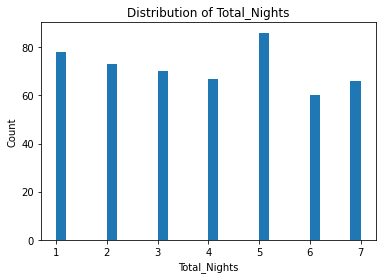

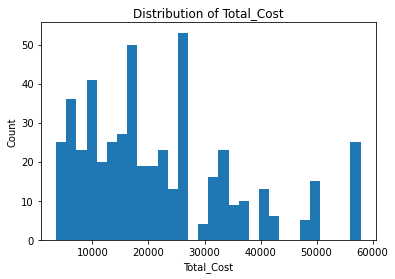

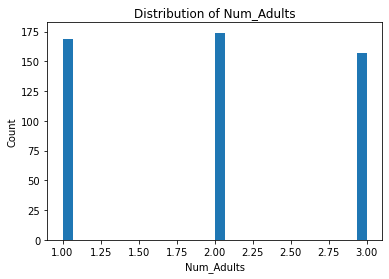

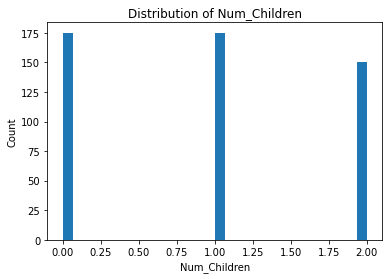

In [22]:
# Distributions for key numerical columns
num_cols = ["Total_Nights","Total_Cost","Num_Adults","Num_Children"]
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.show()

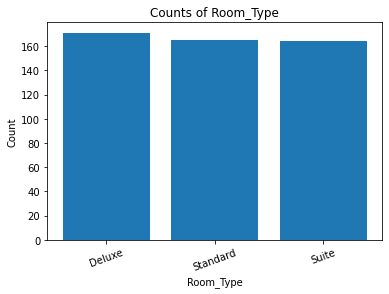

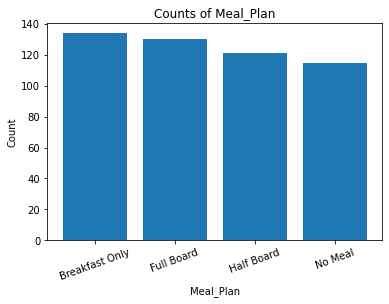

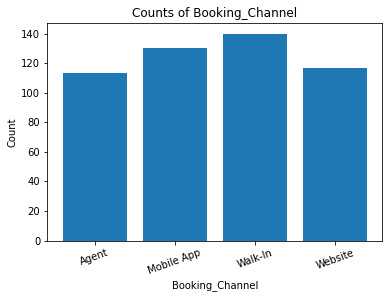

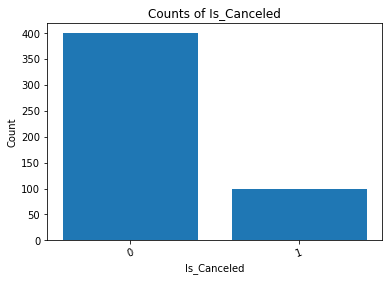

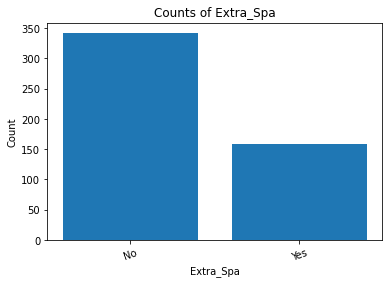

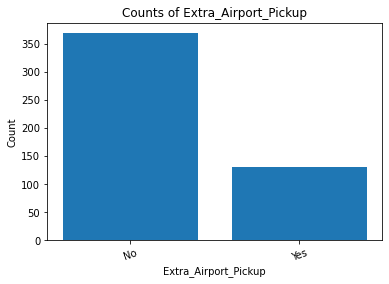

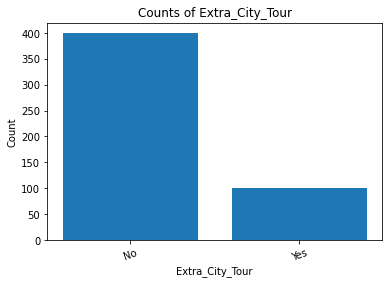

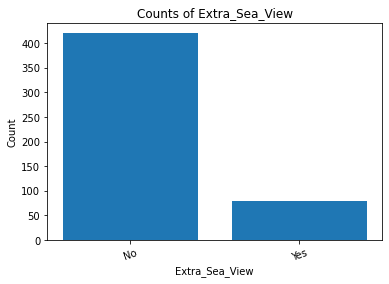

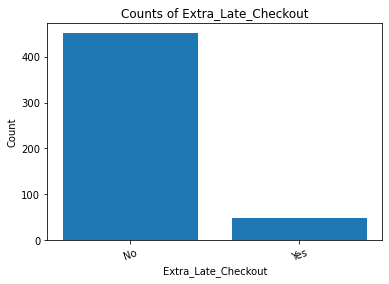

In [23]:
# Bar plots for key categoricals
cat_cols = ["Room_Type","Meal_Plan","Booking_Channel","Is_Canceled",
            "Extra_Spa","Extra_Airport_Pickup","Extra_City_Tour","Extra_Sea_View","Extra_Late_Checkout"]
for col in cat_cols:
    plt.figure()
    vc = df[col].value_counts().sort_index()
    plt.bar(vc.index.astype(str), vc.values)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Counts of {col}')
    plt.xticks(rotation=20)
    plt.show()

## Part A — Association Models (Apriori)
We'll transform each booking into a set of items (e.g., `Room_Type:Suite`, `Meal_Plan:Breakfast`, `Extra_Spa:1`, etc.), one-hot encode them into a basket, then run Apriori and generate rules.

In [27]:
# Convert Yes/No columns into binary 1/0 for Apriori
extras = ['Extra_Spa', 'Extra_Airport_Pickup', 'Extra_City_Tour', 'Extra_Sea_View', 'Extra_Late_Checkout']
for col in extras:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convert Is_Canceled column if needed (assuming it's Yes/No)
if df['Is_Canceled'].dtype == 'object':
    df['Is_Canceled'] = df['Is_Canceled'].map({'Yes': 1, 'No': 0})

# Build transaction items per booking
def transaction_from_row(row):
    items = set()
    items.add(f"Room:{row['Room_Type']}")
    items.add(f"Meal:{row['Meal_Plan']}")
    items.add(f"Channel:{row['Booking_Channel']}")
    items.add(f"Adults:{'3+' if int(row['Num_Adults'])>=3 else row['Num_Adults']}")
    items.add(f"Children:{'1+' if int(row['Num_Children'])>0 else '0'}")
    items.add(f"Nights:{'Long' if int(row['Total_Nights'])>=5 else 'Short'}")
    items.add(f"Spend:{'High' if float(row['Total_Cost'])>=5000 else 'Low'}")
    items.add(f"Cancel:{row['Is_Canceled']}")
    # Include extras
    for ex in extras:
        if row[ex] == 1:
            items.add(ex)
    return sorted(items)

# Generate transactions
transactions = df.apply(transaction_from_row, axis=1).tolist()

# Convert to one-hot encoded basket
all_items = sorted({it for basket in transactions for it in basket})
basket = pd.DataFrame(0, index=range(len(transactions)), columns=all_items, dtype=int)
for i, items in enumerate(transactions):
    basket.loc[i, items] = 1

print("Basket shape:", basket.shape)
basket.head()


Basket shape: (500, 27)


,Adults:1,Adults:2,Adults:3+,Cancel:0,Cancel:1,Channel:Agent,Channel:Mobile App,Channel:Walk-In,Channel:Website,Children:0,...,Meal:Full Board,Meal:Half Board,Meal:No Meal,Nights:Long,Nights:Short,Room:Deluxe,Room:Standard,Room:Suite,Spend:High,Spend:Low
0,0,0,1,1,0,1,0,0,0,1,...,0,1,0,1,0,1,0,0,1,0
1,0,1,0,1,0,1,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0
2,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0
3,0,1,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,1,0
4,0,1,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,1,0


In [33]:
# Apriori (custom) and rule generation
def apriori(basket_df: pd.DataFrame, min_support: float=0.06):
    n_tx = len(basket_df)
    # L1
    support_counts = basket_df.sum(axis=0).to_dict()
    L1 = { (item,): cnt/n_tx for item, cnt in support_counts.items() if cnt/n_tx >= min_support }
    L = [L1]
    k = 2
    while True:
        prev_Lk = L[-1]
        prev_itemsets = list(prev_Lk.keys())
        candidates = set()
        for i in range(len(prev_itemsets)):
            for j in range(i+1, len(prev_itemsets)):
                a = prev_itemsets[i]
                b = prev_itemsets[j]
                union = tuple(sorted(set(a).union(b)))
                if len(union) == k:
                    # prune
                    if all(tuple(sorted(s)) in prev_Lk for s in combinations(union, k-1)):
                        candidates.add(union)
        if not candidates:
            break
        from collections import defaultdict
        candidate_counts = defaultdict(int)
        for _, row in basket_df.iterrows():
            items = set(row.index[row==1])
            for c in candidates:
                if set(c).issubset(items):
                    candidate_counts[c] += 1
        Lk = { c: cnt/len(basket_df) for c, cnt in candidate_counts.items() if cnt/len(basket_df) >= min_support }
        if not Lk:
            break
        L.append(Lk)
        k += 1
    out = []
    for Lk in L:
        for itemset, supp in Lk.items():
            out.append({'itemset': itemset, 'support': supp})
    out = sorted(out, key=lambda x: (-x['support'], x['itemset']))
    return out

def generate_rules(frequent_itemsets: List[Dict], basket_df: pd.DataFrame, min_conf: float=0.45):
    # Lookup support
    supp = { tuple(sorted(fi['itemset'])): fi['support'] for fi in frequent_itemsets }
    n_tx = len(basket_df)
    rules = []
    for fi in frequent_itemsets:
        I = tuple(sorted(fi['itemset']))
        if len(I) < 2:
            continue
        for r in range(1, len(I)):
            for A in combinations(I, r):
                B = tuple(sorted(set(I) - set(A)))
                sX = supp.get(tuple(sorted(A)))
                sY = supp.get(tuple(sorted(B)))
                sXY = supp.get(I)
                if sX is None or sY is None or sXY is None:
                    # compute directly if missing
                    X_cols = list(A)
                    Y_cols = list(B)
                    sX = (basket_df[X_cols].all(axis=1).sum())/n_tx
                    sY = (basket_df[Y_cols].all(axis=1).sum())/n_tx
                    XY_cols = list(I)
                    sXY = (basket_df[XY_cols].all(axis=1).sum())/n_tx
                conf = sXY/sX if sX>0 else 0.0
                lift = sXY/(sX*sY) if (sX>0 and sY>0) else 0.0
                if conf >= min_conf:
                    rules.append({'antecedent': A, 'consequent': B,
                                  'support': sXY, 'confidence': conf, 'lift': lift})
    rules_df = pd.DataFrame(rules)
    if not rules_df.empty:
        rules_df = rules_df.sort_values(['lift','confidence','support'], ascending=False)
    return rules_df

freq_itemsets = apriori(basket, min_support=0.06)
rules_df = generate_rules(freq_itemsets, basket, min_conf=0.45)
print("Frequent itemsets:", len(freq_itemsets))
print("Rules:", 0 if rules_df is None or rules_df.empty else len(rules_df))
rules_df.head(15)

Frequent itemsets: 965
Rules: 2038


,antecedent,consequent,support,confidence,lift
1601,"(Adults:3+, Nights:Long)","(Cancel:0, Room:Deluxe)",0.068,0.465753,1.663405
1607,"(Adults:3+, Nights:Long)","(Cancel:0, Room:Deluxe, Spend:High)",0.068,0.465753,1.663405
1612,"(Adults:3+, Nights:Long, Spend:High)","(Cancel:0, Room:Deluxe)",0.068,0.465753,1.663405
1603,"(Adults:3+, Cancel:0, Nights:Long)","(Room:Deluxe,)",0.068,0.557377,1.629757
1609,"(Adults:3+, Cancel:0, Nights:Long)","(Room:Deluxe, Spend:High)",0.068,0.557377,1.629757
1616,"(Adults:3+, Cancel:0, Nights:Long, Spend:High)","(Room:Deluxe,)",0.068,0.557377,1.629757
1175,"(Nights:Long, Room:Deluxe)","(Adults:3+, Spend:High)",0.080,0.493827,1.624431
1170,"(Adults:3+, Nights:Long)","(Room:Deluxe,)",0.080,0.547945,1.602179
1173,"(Adults:3+, Nights:Long)","(Room:Deluxe, Spend:High)",0.080,0.547945,1.602179
1177,"(Adults:3+, Nights:Long, Spend:High)","(Room:Deluxe,)",0.080,0.547945,1.602179


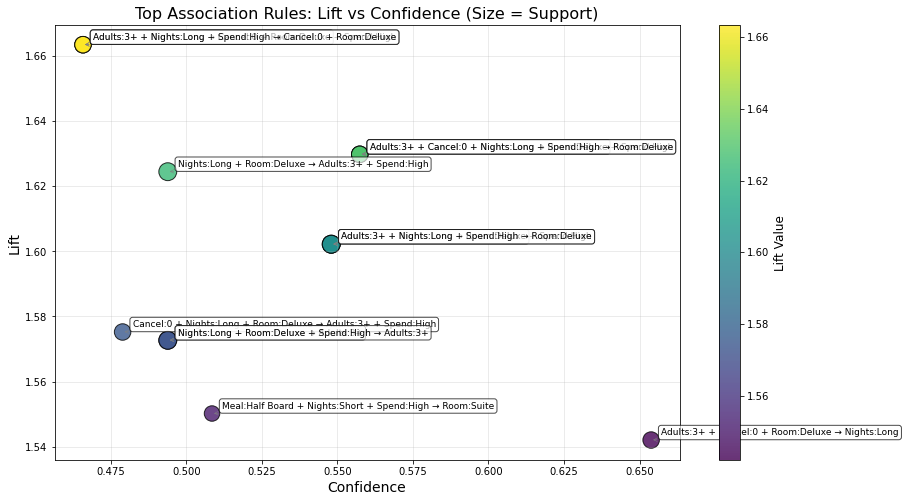

In [34]:
import matplotlib.pyplot as plt

# Visualize Top Rules: Lift vs Confidence (size = Support)
if rules_df is not None and not rules_df.empty:
    # Select top 15 rules for clarity
    top_rules = rules_df.head(15).copy()

    plt.figure(figsize=(14, 8))  # Larger figure for better readability
    scatter = plt.scatter(
        top_rules['confidence'],
        top_rules['lift'],
        s=top_rules['support'] * 4000,
        c=top_rules['lift'],
        cmap='viridis',
        alpha=0.8,
        edgecolors='k'
    )

    plt.xlabel('Confidence', fontsize=14)
    plt.ylabel('Lift', fontsize=14)
    plt.title('Top Association Rules: Lift vs Confidence (Size = Support)', fontsize=16)

    # Annotate each point with rule labels
    for i, row in top_rules.iterrows():
        label = f"{' + '.join(row['antecedent'])} → {' + '.join(row['consequent'])}"
        plt.annotate(
            label,
            (row['confidence'], row['lift']),
            fontsize=9,
            xytext=(10, 5),
            textcoords='offset points',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
            arrowprops=dict(arrowstyle="->", color='gray', lw=0.5)
        )

    # Colorbar for Lift Intensity
    cbar = plt.colorbar(scatter)
    cbar.set_label('Lift Value', fontsize=12)

    plt.grid(alpha=0.3)
    plt.show()

else:
    print("No rules to visualize with current thresholds.")


## Part B — Segmentation Models (K-Means & DBSCAN)
We cluster bookings using numeric behavior features and visualize with PCA.

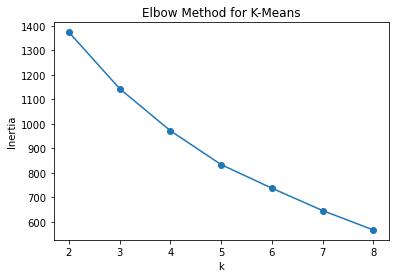

KMeans silhouette: 0.25 | DBI: 1.237


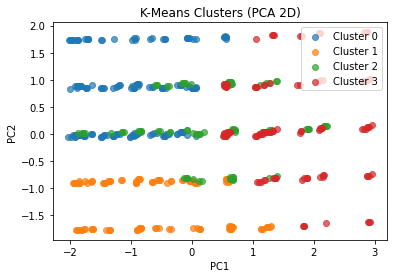

         Total_Nights  Total_Cost  Num_Adults  Num_Children
Cluster                                                    
0                2.54    12954.49        1.33          1.18
1                3.19    15884.41        2.63          0.17
2                4.35    24567.52        2.69          1.74
3                6.16    38723.57        1.64          0.76


In [35]:
# Prepare features
seg_features = ["Total_Nights","Total_Cost","Num_Adults","Num_Children"]
X = df[seg_features].copy().values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method
inertias = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.show()

# Choose k (adjust if elbow suggests)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)

sil_km = silhouette_score(X_scaled, labels_km)
dbi_km = davies_bouldin_score(X_scaled, labels_km)
print('KMeans silhouette:', round(sil_km,3), '| DBI:', round(dbi_km,3))

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
for lab in np.unique(labels_km):
    idx = labels_km == lab
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'Cluster {lab}', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clusters (PCA 2D)')
plt.legend()
plt.show()

# Cluster profiling
work = df.copy()
work['Cluster'] = labels_km
print(work.groupby('Cluster')[seg_features].mean().round(2))

DBSCAN labels: [-1  0  1  2  3  4  5  6  7  8]
DBSCAN silhouette: 0.248 | DBI: 1.762


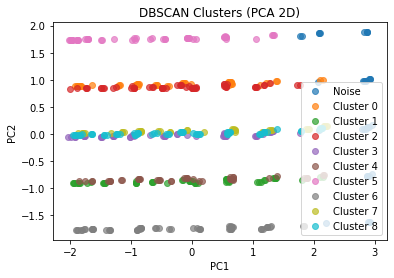

In [36]:
# DBSCAN (robust to noise)
db = DBSCAN(eps=1.2, min_samples=15)
labels_db = db.fit_predict(X_scaled)
print('DBSCAN labels:', np.unique(labels_db))

valid = labels_db != -1
if valid.sum() > 0 and len(set(labels_db)) > 1:
    sil_db = silhouette_score(X_scaled[valid], labels_db[valid])
    dbi_db = davies_bouldin_score(X_scaled[valid], labels_db[valid])
    print('DBSCAN silhouette:', round(sil_db,3), '| DBI:', round(dbi_db,3))
else:
    print('DBSCAN produced a single cluster or all noise; metrics not computed.')

# Visualize DBSCAN
plt.figure()
for lab in np.unique(labels_db):
    idx = labels_db == lab
    label_name = 'Noise' if lab == -1 else f'Cluster {lab}'
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=label_name, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clusters (PCA 2D)')
plt.legend()
plt.show()

## Insights (Template)
- **Association**: Look for rules with high **lift** (>1) and decent **confidence** to form bundles (e.g., `Suite` + `Sea View` + `Spa`).
- **Segments**:
  - Cluster with higher `Total_Nights` and `Total_Cost` → potential **luxury/leisure** segment.
  - Higher `Num_Adults` with moderate nights/spend → **family/business** segment.
  - Low nights/spend → **budget/short-stay** segment.

Adjust thresholds (`min_support`, `min_confidence`) or features to refine results.

Synthetic Dataset

In [37]:
import pandas as pd
import numpy as np
import random

# Set seed for reproducibility
np.random.seed(42)

# Number of rows
n_rows = 500

# Generate Booking_ID & Customer_ID
booking_ids = [f"BKG{1000+i}" for i in range(n_rows)]
customer_ids = [f"CUST{2000+random.randint(1, 800)}" for _ in range(n_rows)]

# Generate Check-In and Check-Out Dates
date_range = pd.date_range(start="2024-01-01", end="2024-12-31")
check_in_dates = np.random.choice(date_range, n_rows)
total_nights = np.random.randint(1, 8, n_rows)
check_out_dates = check_in_dates + pd.to_timedelta(total_nights, unit="D")

# Room Types
room_types = ["Standard", "Deluxe", "Suite"]
room_type = np.random.choice(room_types, n_rows)

# Meal Plan
meal_plans = ["Breakfast Only", "Half Board", "Full Board", "No Meal"]
meal_plan = np.random.choice(meal_plans, n_rows)

# Number of Adults & Children
num_adults = np.random.randint(1, 4, n_rows)
num_children = np.random.randint(0, 3, n_rows)

# Booking Channel
booking_channels = ["Website", "Mobile App", "Agent", "Walk-In"]
booking_channel = np.random.choice(booking_channels, n_rows)

# Is Canceled
is_canceled = np.random.choice([0, 1], n_rows, p=[0.8, 0.2])

# Extras (Yes/No)
extra_options = ["Yes", "No"]
extra_spa = np.random.choice(extra_options, n_rows, p=[0.3, 0.7])
extra_airport_pickup = np.random.choice(extra_options, n_rows, p=[0.25, 0.75])
extra_city_tour = np.random.choice(extra_options, n_rows, p=[0.2, 0.8])
extra_sea_view = np.random.choice(extra_options, n_rows, p=[0.15, 0.85])
extra_late_checkout = np.random.choice(extra_options, n_rows, p=[0.1, 0.9])

# Total Cost Calculation (base rate + extras)
base_prices = {"Standard": 3000, "Deluxe": 5000, "Suite": 8000}
total_cost = [base_prices[r] * nights + np.random.randint(500, 2000)
              for r, nights in zip(room_type, total_nights)]

# Create DataFrame
df = pd.DataFrame({
    "Booking_ID": booking_ids,
    "Customer_ID": customer_ids,
    "Check_In_Date": check_in_dates,
    "Check_Out_Date": check_out_dates,
    "Room_Type": room_type,
    "Meal_Plan": meal_plan,
    "Num_Adults": num_adults,
    "Num_Children": num_children,
    "Booking_Channel": booking_channel,
    "Total_Nights": total_nights,
    "Total_Cost": total_cost,
    "Is_Canceled": is_canceled,
    "Extra_Spa": extra_spa,
    "Extra_Airport_Pickup": extra_airport_pickup,
    "Extra_City_Tour": extra_city_tour,
    "Extra_Sea_View": extra_sea_view,
    "Extra_Late_Checkout": extra_late_checkout
})

# Save to CSV
csv_path = "./synthetic_hospitality_dataset1.csv"
df.to_csv(csv_path, index=False)

csv_path


'./synthetic_hospitality_dataset1.csv'